<a href="https://colab.research.google.com/github/Aarohi-jain84/molecular-property-prediction/blob/main/molecular_property_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Downgrade NumPy for RDKit compatibility
!pip install numpy==1.24.4

# Install RDKit after NumPy downgrade
!pip install rdkit-pypi

In [2]:
import numpy as np
print("NumPy version:", np.__version__)

from rdkit import Chem
mol = Chem.MolFromSmiles('CCO')
print("RDKit works! Molecule:", mol)


NumPy version: 1.24.4
RDKit works! Molecule: <rdkit.Chem.rdchem.Mol object at 0x78b7fa75ce40>


In [3]:
import pandas as pd

# Sample data: SMILES strings and known LogP values
data = {
    'SMILES': ['CCO', 'CCCC', 'CCN', 'CCCl', 'c1ccccc1', 'CC(=O)O', 'C1CCCCC1', 'CCBr', 'CC(C)O', 'CC(C)C'],
    'LogP': [0.3, 2.0, -0.3, 1.4, 1.5, -0.2, 2.5, 1.5, 0.4, 1.9]
}

df = pd.DataFrame(data)
df.head()


,SMILES,LogP
0,CCO,0.3
1,CCCC,2.0
2,CCN,-0.3
3,CCCl,1.4
4,c1ccccc1,1.5


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Function to compute descriptors from a SMILES string
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return [
        Descriptors.MolWt(mol),          # Molecular weight
        Descriptors.MolLogP(mol),        # LogP (hydrophobicity)
        Descriptors.NumHDonors(mol),     # Number of hydrogen donors
        Descriptors.NumHAcceptors(mol),  # Number of hydrogen acceptors
        Descriptors.TPSA(mol)            # Topological polar surface area
    ]

# Apply to the dataset
features = df['SMILES'].apply(compute_descriptors)
features_df = pd.DataFrame(features.tolist(), columns=['MolWt', 'LogP_RDKit', 'HDonors', 'HAcceptors', 'TPSA'])

# Combine features with target
final_df = pd.concat([features_df, df['LogP']], axis=1)
final_df.head()


,MolWt,LogP_RDKit,HDonors,HAcceptors,TPSA,LogP
0,46.069,-0.0014,1,1,20.23,0.3
1,58.124,1.8064,0,0,0.00,2.0
2,45.085,-0.0350,1,1,26.02,-0.3
3,64.515,1.2451,0,0,0.00,1.4
4,78.114,1.6866,0,0,0.00,1.5


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Split features and target
X = final_df.drop('LogP', axis=1)
y = final_df['LogP']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: Predict on test set
y_pred = model.predict(X_test)

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.0583
R² Score: 0.9089


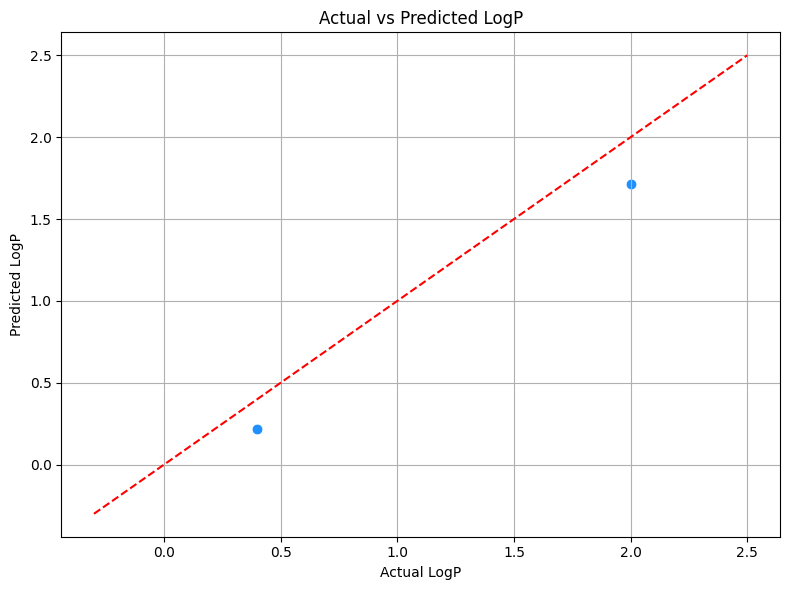

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot predicted vs actual values
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color='dodgerblue', s=60)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Actual LogP')
plt.ylabel('Predicted LogP')
plt.title('Actual vs Predicted LogP')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
def predict_logp(smiles_input):
    mol = Chem.MolFromSmiles(smiles_input)
    if mol is None:
        print("Invalid SMILES string. Please check your input.")
        return

    features = [Descriptors.MolWt(mol),
                Descriptors.NumHDonors(mol),
                Descriptors.NumHAcceptors(mol),
                Descriptors.MolLogP(mol),
                Descriptors.TPSA(mol)]

    prediction = model.predict([features])[0]
    print(f"Predicted LogP for {smiles_input}: {prediction:.4f}")


In [10]:
predict_logp("CCO")  # Ethanol

Predicted LogP for CCO: 0.9240


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
